Data Set Information:

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.


Attribute Information:

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.  
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.  
Description: Product (item) name. Nominal.  
Quantity: The quantities of each product (item) per transaction. Numeric.  
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.  
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).  
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.  
Country: Country name. Nominal. The name of the country where a customer resides.


https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt 
import seaborn as sns

import pickle 

import datetime 

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import metrics

import plotly.graph_objects as go
import plotly.express as px

pd.set_option('display.max_rows', 100)

%config InlineBackend.figure_format = 'svg'

### Importing the File 

In [2]:
file = 'online_retail_II.xlsx'

In [3]:
df_0910 = pd.read_excel(file, sheet_name = 'Year 2009-2010')
df_0910.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [4]:
df_1011 = pd.read_excel(file, sheet_name = 'Year 2010-2011')
df_1011.head()

Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom

### Data Cleaning 

In [5]:
df_0910['Year'] = '2009-2010'
df_1011['Year'] = '2010-2011'

In [6]:
df = df_0910.append(df_1011, sort=False)

In [7]:
print(len(df_0910))
print(len(df_1011))
print(len(df))

525461
541910
1067371


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 9 columns):
Invoice        1067371 non-null object
StockCode      1067371 non-null object
Description    1062989 non-null object
Quantity       1067371 non-null int64
InvoiceDate    1067371 non-null datetime64[ns]
Price          1067371 non-null float64
Customer ID    824364 non-null float64
Country        1067371 non-null object
Year           1067371 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 81.4+ MB


In [9]:
#There are missing values in the Customer ID amd Description columns 
df.dropna(inplace = True)

In [10]:
#Casting Customer ID as string 
df['Customer ID'] = df['Customer ID'].astype('object')

In [11]:
df.describe()

Quantity          Price
count  824364.000000  824364.000000
mean       12.414574       3.676800
std       188.976099      70.241388
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000

In [12]:
df[df['Quantity']<0]

#negative quantities appear with cancelled orders (as we can tell from the invoice)

Invoice StockCode                       Description  Quantity  \
178     C489449     22087          PAPER BUNTING WHITE LACE       -12   
179     C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180     C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181     C489449     21896                POTTING SHED TWINE        -6   
182     C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...         ...       ...                               ...       ...   
540449  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541  C581499         M                            Manual        -1   
541715  C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717  C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate   Price Customer ID         Country       Year  
178    2009-12-01 10:33:00    2.95       16321       Australia  2009-2010  
179    2009-12-01 10:33:00    1.65       16321       Australia  2009-2010  
180    2009-12-01 10:33:00    4.25       16321       Australia  2009-2010  
181    2009-12-01 10:33:00    2.10       16321       Australia  2009-2010  
182    2009-12-01 10:33:00    2.95       16321       Australia  2009-2010  
...                    ...     ...         ...             ...        ...  
540449 2011-12-09 09:57:00    0.83       14397  United Kingdom  2010-2011  
541541 2011-12-09 10:28:00  224.69       15498  United Kingdom  2010-2011  
541715 2011-12-09 11:57:00   10.95       15311  United Kingdom  2010-2011  
541716 2011-12-09 11:58:00    1.25       17315  United Kingdom  2010-2011  
541717 2011-12-09 11:58:00    1.25       17315  United Kingdom  2010-2011  

[18744 rows x 9 columns]

In [13]:
#Removing negative quantities 
df = df[df['Quantity']>0]

In [14]:
#The max values for quantity and price are also suspicious 
df[df['Quantity'] == 80995] 

#Large quantities may be attributed to wholesalers 

Invoice StockCode                  Description  Quantity  \
540421  581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  Price Customer ID         Country       Year  
540421 2011-12-09 09:15:00   2.08       16446  United Kingdom  2010-2011

In [15]:
df[df['Price']>300]

#Large prices on the other hand seem to be attributed to 'special' items
#Manual, post, adjust... all these have strange stockcodes, so maybe we can use this to filter 

Invoice StockCode     Description  Quantity         InvoiceDate  \
22960   491176         M          Manual         1 2009-12-10 11:50:00   
38943   492650         M          Manual         1 2009-12-17 17:43:00   
48318   493897         M          Manual         1 2010-01-08 10:39:00   
48348   493900         M          Manual         1 2010-01-08 10:44:00   
51493   494042         M          Manual         1 2010-01-11 11:57:00   
...        ...       ...             ...       ...                 ...   
467437  576339       DOT  DOTCOM POSTAGE         1 2011-11-14 15:27:00   
468046  576389         M          Manual         1 2011-11-15 10:05:00   
494727  578270       DOT  DOTCOM POSTAGE         1 2011-11-23 13:39:00   
508459  579196       DOT  DOTCOM POSTAGE         1 2011-11-28 15:54:00   
528083  580727       DOT  DOTCOM POSTAGE         1 2011-12-05 17:17:00   

          Price Customer ID         Country       Year  
22960   1213.02       13091  United Kingdom  2009-2010  
38943    803.25       14911            EIRE  2009-2010  
48318    780.52       14911            EIRE  2009-2010  
48348    780.52       14911            EIRE  2009-2010  
51493    975.11       12510           Spain  2009-2010  
...         ...         ...             ...        ...  
467437  1500.36       14096  United Kingdom  2010-2011  
468046   850.50       12748  United Kingdom  2010-2011  
494727  1270.06       14096  United Kingdom  2010-2011  
508459  1526.76       14096  United Kingdom  2010-2011  
528083  1599.26       14096  United Kingdom  2010-2011  

[110 rows x 9 columns]

In [16]:
import re

def abnormal_code(code):
    '''remove stockcodes or invoices that start with a letter'''
    pattern =  '^[a-zA-Z]'
    if re.search(pattern, str(code)): 
        return(np.nan) 
    else: return(code) 

In [17]:
#Dropping Stockcodes and Invoices that start with a letter
df['StockCode'] = df['StockCode'].apply(lambda x:abnormal_code(x))
df['Invoice'] = df['Invoice'].apply(lambda x:abnormal_code(x))
df.dropna(inplace = True)

In [18]:
#Stockcodes are support to be 5 digit, checking if this is consistent across the dataset
df['StockCode_length'] = df['StockCode'].apply(lambda x:len(str(x)))

In [19]:
df[df['StockCode_length']>5]
df.drop(columns = 'StockCode_length', inplace = True)
#Stockcodes that end with a letter appear to indicate colour variations of an item 

In [20]:
print(len(df['Invoice'].unique()))
print(len(df['StockCode'].unique()))
print(len(df['Description'].unique()))
#Unique StockCodes don't appear to tally with unique descriptions 

print(len(df['Customer ID'].unique()))
print(len(df['Country'].unique()))

36597
4619
5270
5853
41


In [21]:
#number of unique descriptions and stockcodes do not tally 
stock = df.groupby(['StockCode','Description']).count().reset_index()
stock[stock.duplicated(['StockCode'])]

#looks like some of the items descriptions have changed, but they appear to be the same item 

StockCode                       Description  Invoice  Quantity  \
17       16011                   ANIMAL STICKERS      104       104   
19       16012        FOOD/DRINK SPUNGE STICKERS       20        20   
64       20615        BLUE SPOTTY PASSPORT COVER       39        39   
72       20622                VIPPASSPORT COVER        74        74   
74       20652          BLUE SPOTTY LUGGAGE TAG        46        46   
...        ...                               ...      ...       ...   
5000    85232A      SET/3 POLKADOT STACKING TINS       37        37   
5002    85232B  SET/3 RUSSIAN DOLL STACKING TINS      304       304   
5038    90014A         SILVER/MOP ORBIT NECKLACE       19        19   
5040    90014B        GOLD M.O.P. ORBIT NECKLACE        2         2   
5042    90014C       SILVER/BLACK ORBIT NECKLACE       13        13   

      InvoiceDate  Price  Customer ID  Country  Year  
17            104    104          104      104   104  
19             20     20           20       20    20  
64             39     39           39       39    39  
72             74     74           74       74    74  
74             46     46           46       46    46  
...           ...    ...          ...      ...   ...  
5000           37     37           37       37    37  
5002          304    304          304      304   304  
5038           19     19           19       19    19  
5040            2      2            2        2     2  
5042           13     13           13       13    13  

[682 rows x 9 columns]

In [22]:
df['Country'].value_counts()

United Kingdom          724479
Germany                  16042
EIRE                     15526
France                   13322
Netherlands               4988
Spain                     3618
Switzerland               2957
Belgium                   2924
Portugal                  2381
Australia                 1809
Channel Islands           1561
Italy                     1436
Norway                    1411
Sweden                    1269
Cyprus                    1151
Finland                    985
Austria                    888
Denmark                    775
Greece                     653
Unspecified                521
Poland                     506
Japan                      485
USA                        404
United Arab Emirates       380
Singapore                  332
Israel                     322
Malta                      277
Iceland                    253
Canada                     227
Lithuania                  189
RSA                        122
Brazil                      94
Thailand

In [23]:
df.reset_index(drop = True, inplace = True)

In [24]:
pd.to_datetime(df['InvoiceDate']) 

0        2009-12-01 07:45:00
1        2009-12-01 07:45:00
2        2009-12-01 07:45:00
3        2009-12-01 07:45:00
4        2009-12-01 07:45:00
                 ...        
802688   2011-12-09 12:50:00
802689   2011-12-09 12:50:00
802690   2011-12-09 12:50:00
802691   2011-12-09 12:50:00
802692   2011-12-09 12:50:00
Name: InvoiceDate, Length: 802693, dtype: datetime64[ns]

In [339]:
#df.to_pickle('df.pickle')
with open('df.pickle','rb') as read_file:
     df = pickle.load(read_file)


In [344]:
df

Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
802688   581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
802689   581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
802690   581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
802691   581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
802692   581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country       Year  \
0      2009-12-01 07:45:00   6.95       13085  United Kingdom  2009-2010   
1      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
2      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
3      2009-12-01 07:45:00   2.10       13085  United Kingdom  2009-2010   
4      2009-12-01 07:45:00   1.25       13085  United Kingdom  2009-2010   
...                    ...    ...         ...             ...        ...   
802688 2011-12-09 12:50:00   0.85       12680          France  2010-2011   
802689 2011-12-09 12:50:00   2.10       12680          France  2010-2011   
802690 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802691 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802692 2011-12-09 12:50:00   4.95       12680          France  2010-2011   

        Clusters  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
802688       0.0  
802689       0.0  
802690       0.0  
802691       0.0  
802692       0.0  

[802693 rows x 10 columns]

### Feature Engineering 

#### Total Price per Line Item 

In [27]:
df['total_for_item'] = df['Price']*df['Quantity']

#### Total Price per Invoice 

In [28]:
total_invoice_price = df[['Invoice','total_for_item']] 

In [29]:
total_invoice_price = total_invoice_price.groupby(['Invoice']).sum()

In [30]:
total_invoice_price.columns = ['invoice_price']

In [31]:
total_invoice_price

invoice_price
Invoice               
489434          505.30
489435          145.80
489436          630.33
489437          310.75
489438         2286.24
...                ...
581583          124.60
581584          140.64
581585          329.05
581586          339.20
581587          249.45

[36597 rows x 1 columns]

In [32]:
df[df['Invoice'] == 489435]

Invoice StockCode                         Description  Quantity  \
8    489435     22350                           CAT BOWL         12   
9    489435     22349      DOG BOWL , CHASING BALL DESIGN        12   
10   489435     22195        HEART MEASURING SPOONS LARGE        24   
11   489435     22353  LUNCHBOX WITH CUTLERY FAIRY CAKES         12   

           InvoiceDate  Price Customer ID         Country       Year  \
8  2009-12-01 07:46:00   2.55       13085  United Kingdom  2009-2010   
9  2009-12-01 07:46:00   3.75       13085  United Kingdom  2009-2010   
10 2009-12-01 07:46:00   1.65       13085  United Kingdom  2009-2010   
11 2009-12-01 07:46:00   2.55       13085  United Kingdom  2009-2010   

    total_for_item  
8             30.6  
9             45.0  
10            39.6  
11            30.6

In [33]:
df = df.merge(total_invoice_price, on = 'Invoice')

#### Time Between Orders 

In [34]:
customer_orders = df[['Customer ID','InvoiceDate','Invoice']].drop_duplicates('Invoice').sort_values(['Customer ID','Invoice'])

In [35]:
customer_orders['time_diff'] = customer_orders.groupby(['Customer ID'])['InvoiceDate'].diff()
customer_orders.drop(columns = ['Customer ID','InvoiceDate'], inplace = True)

In [36]:
customer_orders.min()

Invoice               489434
time_diff    0 days 00:00:00
dtype: object

In [37]:
df = df.merge(customer_orders, on = 'Invoice')

#### Total Quantity per Order 

In [38]:
total_invoice_quantity = df[['Invoice','Quantity']] 
total_invoice_quantity = total_invoice_quantity.groupby(['Invoice']).sum()

In [39]:
total_invoice_quantity.columns= ['total_quantity']

In [40]:
total_invoice_quantity

total_quantity
Invoice                
489434              166
489435               60
489436              193
489437              145
489438              826
...                 ...
581583               76
581584              120
581585              278
581586               66
581587              105

[36597 rows x 1 columns]

In [41]:
df = df.merge(total_invoice_quantity, on = 'Invoice')

In [345]:
#df.to_pickle('df_FE.pickle')
with open('df_FE.pickle','rb') as read_file:
     df = pickle.load(read_file)


In [43]:
#comparing revenues for the past 2 years 
df.drop_duplicates(['Invoice']).groupby(['Year'])['invoice_price'].sum()

Year
2009-2010    8982907.08
2010-2011    8451542.90
Name: invoice_price, dtype: float64

In [44]:
df

Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
802688   581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
802689   581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
802690   581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
802691   581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
802692   581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country       Year  \
0      2009-12-01 07:45:00   6.95       13085  United Kingdom  2009-2010   
1      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
2      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
3      2009-12-01 07:45:00   2.10       13085  United Kingdom  2009-2010   
4      2009-12-01 07:45:00   1.25       13085  United Kingdom  2009-2010   
...                    ...    ...         ...             ...        ...   
802688 2011-12-09 12:50:00   0.85       12680          France  2010-2011   
802689 2011-12-09 12:50:00   2.10       12680          France  2010-2011   
802690 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802691 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802692 2011-12-09 12:50:00   4.95       12680          France  2010-2011   

        total_for_item  invoice_price        time_diff  total_quantity  
0                83.40         505.30              NaT             166  
1                81.00         505.30              NaT             166  
2                81.00         505.30              NaT             166  
3               100.80         505.30              NaT             166  
4                30.00         505.30              NaT             166  
...                ...            ...              ...             ...  
802688           10.20         249.45 72 days 23:57:00             105  
802689           12.60         249.45 72 days 23:57:00             105  
802690           16.60         249.45 72 days 23:57:00             105  
802691           16.60         249.45 72 days 23:57:00             105  
802692           14.85         249.45 72 days 23:57:00             105  

[802693 rows x 13 columns]

### Clustering based on RFM segmentation

RFM segmentation 
- Recency: how long since the customer last transacted with the company 
- Frequency: how often has the customer transacted across a particular period of time 
- Monetary value: how much the customer has spent across a particular period of time

In [45]:
#Create a new df that aggregates customer information 
customer_profile = (df[['Customer ID','Invoice','invoice_price']]
                    .drop_duplicates(subset=['Invoice'], keep='last'))


In [46]:
#Getting frequency and monetary value of customer 
customer_profile =  pd.DataFrame(customer_profile.groupby(['Customer ID']).agg({'Invoice':'count',
                                                                    'invoice_price':'sum'}))
                                    

In [47]:
#Cast Customer ID as string instead of float 
customer_profile.reset_index(inplace = True)
customer_profile['Customer ID'] = customer_profile['Customer ID'].astype('object')

In [48]:
customer_profile

Customer ID  Invoice  invoice_price
0          12346        3       77352.96
1          12347        8        5633.32
2          12348        5        1658.40
3          12349        3        3678.69
4          12350        1         294.40
...          ...      ...            ...
5848       18283       22        2730.70
5849       18284        1         411.68
5850       18285        1         377.00
5851       18286        2        1246.43
5852       18287        7        4132.99

[5853 rows x 3 columns]

In [49]:
df[df['Customer ID']==18286].drop_duplicates(['Invoice'])

Invoice StockCode                   Description  Quantity  \
24730    492250    72801C  S/4 ROSE PINK DINNER CANDLES        12   
238309   519785     20978        36 PENCILS TUBE SKULLS        16   

               InvoiceDate  Price Customer ID         Country       Year  \
24730  2009-12-16 10:45:00   1.25       18286  United Kingdom  2009-2010   
238309 2010-08-20 11:57:00   1.25       18286  United Kingdom  2009-2010   

        total_for_item  invoice_price         time_diff  total_quantity  
24730             15.0         412.95               NaT             113  
238309            20.0         833.48 247 days 01:12:00             494

In [50]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [51]:
#Calculate time since last purchase, assume today is last date in dataframe 
time_since_last_purchase = (df[['Customer ID','Invoice','InvoiceDate']]
                            .sort_values(['InvoiceDate'])
                            .drop_duplicates(subset=['Customer ID'], keep='last'))

In [52]:
date_today = datetime.datetime.strptime('2011-12-09 12:50:00','%Y-%m-%d %H:%M:%S')

In [53]:
time_since_last_purchase['last_purchase'] = (time_since_last_purchase['InvoiceDate']
                                             .apply(lambda x: date_today-x)
                                             .apply(lambda x:x.days))

In [54]:
customer_profile = customer_profile.merge(time_since_last_purchase[['Customer ID','last_purchase']], on='Customer ID')

In [55]:
customer_profile.columns = ['Customer ID','Frequency','Monetary Value','Recency']

In [320]:
#customer_profile.to_pickle('customers.pickle')

with open('customers.pickle','rb') as read_file:
     customer_profile = pickle.load(read_file)


In [295]:
customer_profile['Monetary Value'].sum()

17434449.979999997

### Segment Customers using Clustering 

In [296]:
X = customer_profile[['Frequency','Monetary Value','Recency']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [297]:
fig = px.scatter_3d(X, x=X[:,0], y=X[:,1], z=X[:,2])
fig.show()

In [298]:
#Data has some extreme outliers. 
#Let's identify them using standard deviation and drop them 

X = customer_profile[['Frequency','Monetary Value','Recency']].copy()

def replace_outliers(x):
    if x>4 or x<-4: 
        return np.nan
    else: return x

for column in X.columns:
    mean = X[column].mean()
    std = X[column].std()
    X[column] = (X[column]-mean)/std  
    X[column] = X[column].apply(lambda x:replace_outliers(x)) 

X.dropna(inplace = True)

In [299]:
#converting into an array 
X = X.values

When ground truth is unknown, the following can be used to evaluate clustering algos:
    
- Silhouette Coefficient
- Davies-Bouldin Index
- Calinski-Harabasz Index


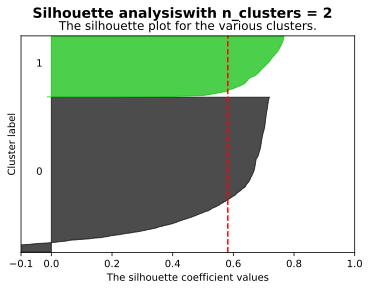

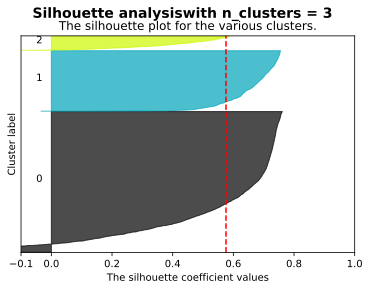

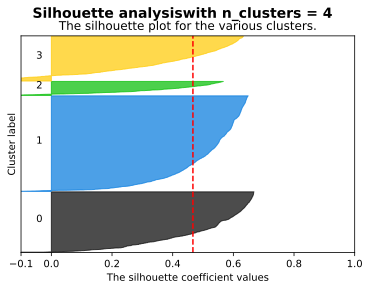

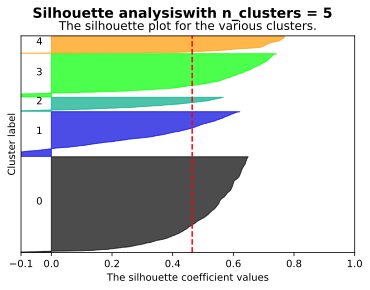

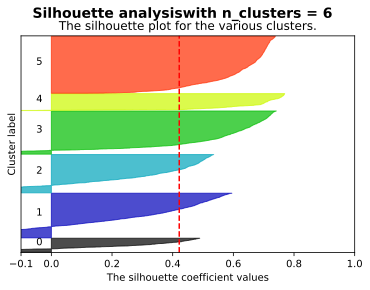

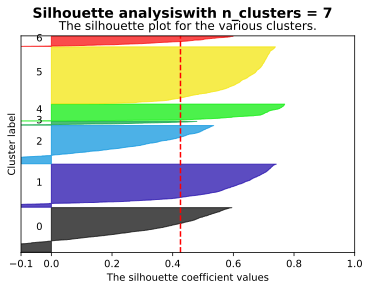

In [62]:
#Evaluate K-means and Hierarchical models (ward) 

#Hierarchical 
range_n_clusters = range(2,8)
eval_scores = {'model':[],'n_clusters':[], 's_score':[], 'c_score':[], 'db_score':[]}

for n_clusters in range_n_clusters:

    fig=plt.figure()
    ax=plt.axes()
    
    ax.set_xlim([-0.1, 1])

    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    eval_scores['model'].append('Hier')
    
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels, random_state = 77)
   
    eval_scores['n_clusters'].append(n_clusters)
    eval_scores['s_score'].append(silhouette_avg)
    eval_scores['c_score'].append(metrics.calinski_harabasz_score(X, cluster_labels))
    eval_scores['db_score'].append(davies_bouldin_score(X, cluster_labels))
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

hier_scores = pd.DataFrame(eval_scores) 

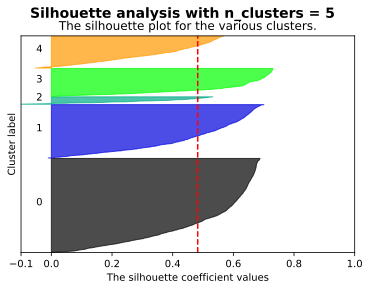

In [115]:
#K-means 

range_n_clusters = range(5,6)
eval_scores = {'model':[],'n_clusters':[], 's_score':[], 'c_score':[], 'db_score':[]}

for n_clusters in range_n_clusters:

    fig=plt.figure()
    ax=plt.axes()
    
    ax.set_xlim([-0.1, 1])

    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=77, init='k-means++')
    eval_scores['model'].append('KMeans')
    
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels, random_state = 77)
   
    eval_scores['n_clusters'].append(n_clusters)
    eval_scores['s_score'].append(silhouette_avg)
    eval_scores['c_score'].append(metrics.calinski_harabasz_score(X, cluster_labels))
    eval_scores['db_score'].append(metrics.davies_bouldin_score(X, cluster_labels))
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
fig.savefig('silhouette.png')


In [64]:
scores = pd.DataFrame(eval_scores).append(hier_scores)
scores.sort_values('n_clusters')

#Models are very similar in terms of their silhoutte scores
#For both models, from n_clusters = 6 to 7
#K-means outperforms at n_clusters = 6  

model  n_clusters   s_score       c_score  db_score
0  KMeans           2  0.594541   9287.857137  0.582639
0    Hier           2  0.581698   8521.917647  0.559888
1  KMeans           3  0.588156   9103.469922  0.649014
1    Hier           3  0.575753   8345.117355  0.636482
2  KMeans           4  0.551103   9660.242059  0.642604
2    Hier           4  0.466708   8437.090592  0.738229
3  KMeans           5  0.482530   9766.915301  0.728177
3    Hier           5  0.464246   8610.110926  0.690028
4  KMeans           6  0.499492  10651.544193  0.669170
4    Hier           6  0.421601   8607.585845  0.707550
5  KMeans           7  0.479581  10572.080223  0.731764
5    Hier           7  0.425663   8985.403381  0.752059

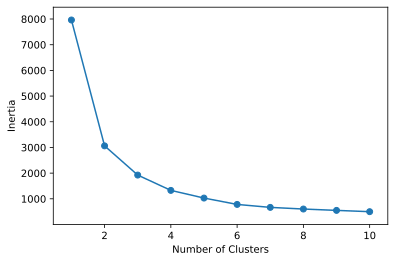

In [65]:
#Checking inertia for k-means 
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=77)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

#### DBSCAN

In [108]:
db = DBSCAN(eps=0.18)
db.fit(X)

DBSCAN(algorithm='auto', eps=0.18, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [109]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

4


In [110]:
print(silhouette_score(X, db.labels_, random_state = 77))
print(metrics.calinski_harabasz_score(X, db.labels_))
print(metrics.davies_bouldin_score(X, db.labels_))

-0.06805668795892754
111.33449071074104
1.4255295991457353


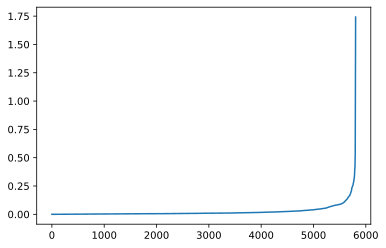

In [83]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### Clustering with K-Means (n_clusters = 5)

In [300]:
km = KMeans(n_clusters=5,random_state=77)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=77, tol=0.0001, verbose=0)

In [301]:
fig = px.scatter_3d(X, x=X[:,0], y=X[:,1], z=X[:,2], color=km.labels_)
fig.show()

In [321]:
customer_profile[['Frequency_raw','Monetary Value_raw','Recency_raw']] = customer_profile[['Frequency','Monetary Value','Recency']].copy()

X = customer_profile[['Frequency','Monetary Value','Recency']].copy()

for column in X.columns:
    mean = customer_profile[column].mean()
    std = customer_profile[column].std()
    customer_profile[column] = (customer_profile[column]-mean)/std  
    customer_profile[column] = customer_profile[column].apply(lambda x:replace_outliers(x)) 


customer_profile.dropna(inplace = True)

In [322]:
customer_profile['clusters'] = km.labels_

In [323]:
customer_profile

Customer ID  Frequency  Monetary Value   Recency  Frequency_raw  \
1          12347   0.137041        0.181775 -0.950410              8   
2          12348  -0.098248       -0.090410 -0.600301              5   
3          12349  -0.255107        0.047931 -0.868878              3   
4          12350  -0.411967       -0.183810  0.526766              1   
5          12351  -0.411967       -0.183363  0.838507              1   
...          ...        ...             ...       ...            ...   
5848       18283   1.235056       -0.016983 -0.940818             22   
5849       18284  -0.411967       -0.175779  1.111881              1   
5850       18285  -0.411967       -0.178154  2.210171              1   
5851       18286  -0.333537       -0.118619  1.327702              2   
5852       18287   0.058611        0.079039 -0.753773              7   

      Monetary Value_raw  Recency_raw  clusters  
1                5633.32            1         4  
2                1658.40           74         0  
3                3678.69           18         0  
4                 294.40          309         1  
5                 300.93          374         1  
...                  ...          ...       ...  
5848             2730.70            3         4  
5849              411.68          431         1  
5850              377.00          660         3  
5851             1246.43          476         3  
5852             4132.99           42         0  

[5806 rows x 8 columns]

In [324]:
#customer_profile.to_pickle('customers_clusters.pickle')

with open('customers_clusters.pickle','rb') as read_file:
     customer_profile = pickle.load(read_file)

In [325]:
customer_profile.groupby('clusters').describe().transpose()

clusters                             0             1             2  \
Frequency          count   2540.000000   1446.000000    201.000000   
                   mean      -0.210458     -0.286837      2.064616   
                   std        0.166980      0.173438      0.701958   
                   min       -0.411967     -0.411967      0.686048   
                   25%       -0.333537     -0.411967      1.548775   
                   50%       -0.255107     -0.333537      1.862493   
                   75%       -0.098248     -0.255107      2.489931   
                   max        0.293900      1.078197      3.980094   
Monetary Value     count   2540.000000   1446.000000    201.000000   
                   mean      -0.121669     -0.145879      0.859285   
                   std        0.079090      0.075846      0.671174   
                   min       -0.203969     -0.203712      0.011913   
                   25%       -0.175179     -0.186227      0.425199   
                   50%       -0.143051     -0.168606      0.662632   
                   75%       -0.093754     -0.134283      1.071436   
                   max        0.990083      0.739667      3.850131   
Recency            count   2540.000000   1446.000000    201.000000   
                   mean      -0.645602      0.736384     -0.829221   
                   std        0.269221      0.360985      0.313988   
                   min       -0.955206      0.037571     -0.955206   
                   25%       -0.859286      0.397273     -0.945614   
                   50%       -0.720201      0.843303     -0.916838   
                   75%       -0.507977      1.025552     -0.864082   
                   max        0.056755      1.327702      1.577095   
Frequency_raw      count   2540.000000   1446.000000    201.000000   
                   mean       3.569291      2.595436     32.577114   
                   std        2.129040      2.211378      8.950155   
                   min        1.000000      1.000000     15.000000   
                   25%        2.000000      1.000000     26.000000   
                   50%        3.000000      2.000000     30.000000   
                   75%        5.000000      3.000000     38.000000   
                   max       10.000000     20.000000     57.000000   
Monetary Value_raw count   2540.000000   1446.000000    201.000000   
                   mean    1201.886945    848.332898  15527.520050   
                   std     1155.012492   1107.635005   9801.676407   
                   min        0.000000      3.750000   3152.690000   
                   25%      420.450000    259.110000   9188.230000   
                   50%      889.635000    516.435000  12655.650000   
                   75%     1609.562500   1017.687500  18625.730000   
                   max    17437.660000  13780.650000  59205.150000   
Recency_raw        count   2540.000000   1446.000000    201.000000   
                   mean      64.554331    352.706777     26.268657   
                   std       56.134283     75.267531     65.468370   
                   min        0.000000    207.000000      0.000000   
                   25%       20.000000    282.000000      2.000000   
                   50%       49.000000    375.000000      8.000000   
                   75%       93.250000    413.000000     19.000000   
                   max      211.000000    476.000000    528.000000   

clusters                             3             4  
Frequency          count    758.000000    861.000000  
                   mean      -0.359301      0.530556  
                   std        0.133253      0.315908  
                   min       -0.411967     -0.255107  
                   25%       -0.411967      0.293900  
                   50%       -0.411967      0.450760  
                   75%       -0.333537      0.686048  
                   max        1.627204      1.470345  
Monetary Value     count    758.000000    861.000000  
                   

In [326]:
customer_profile.drop(columns=['Frequency','Monetary Value','Recency'], inplace = True)

In [327]:
customer_profile

Customer ID  Frequency_raw  Monetary Value_raw  Recency_raw  clusters
1          12347              8             5633.32            1         4
2          12348              5             1658.40           74         0
3          12349              3             3678.69           18         0
4          12350              1              294.40          309         1
5          12351              1              300.93          374         1
...          ...            ...                 ...          ...       ...
5848       18283             22             2730.70            3         4
5849       18284              1              411.68          431         1
5850       18285              1              377.00          660         3
5851       18286              2             1246.43          476         3
5852       18287              7             4132.99           42         0

[5806 rows x 5 columns]

In [328]:
customer_profile.columns=['Customer ID','Frequency','Monetary Value','Recency','Clusters']

In [ ]:
sns.set(style="ticks")

sns.pairplot(customer_profile, hue="Clusters", plot_kws=dict(alpha=0.5))

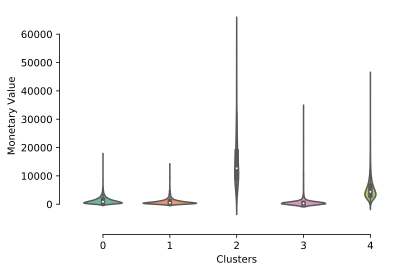

In [329]:
sns.violinplot(x="Clusters", y="Monetary Value",
            data=customer_profile, palette="Set2")
sns.despine(offset=10, trim=True)

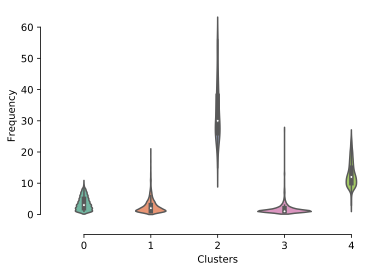

In [330]:
sns.violinplot(x="Clusters", y="Frequency",
            data=customer_profile, palette="Set2")

sns.despine(offset=10, trim=True)

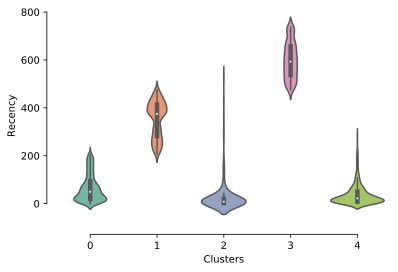

In [331]:
sns.violinplot(x="Clusters", y="Recency",
            data=customer_profile, palette="Set2")
sns.despine(offset=10, trim=True)


In [369]:
fig = px.scatter_3d(customer_profile, x='Frequency',
                    y='Recency', z='Monetary Value',
                    color='Clusters', color_continuous_scale='sunset')
fig.show()

In [333]:
#customer_profile.to_pickle('customers_clusters2.pickle')

with open('customers_clusters2.pickle','rb') as read_file:
     customer_profile = pickle.load(read_file)

In [334]:
customer_profile

Customer ID  Frequency  Monetary Value  Recency  Clusters
1          12347          8         5633.32        1         4
2          12348          5         1658.40       74         0
3          12349          3         3678.69       18         0
4          12350          1          294.40      309         1
5          12351          1          300.93      374         1
...          ...        ...             ...      ...       ...
5848       18283         22         2730.70        3         4
5849       18284          1          411.68      431         1
5850       18285          1          377.00      660         3
5851       18286          2         1246.43      476         3
5852       18287          7         4132.99       42         0

[5806 rows x 5 columns]

### Merge clusters back into invoice dataframe 

In [346]:
customerid_cluster = customer_profile[['Customer ID','Clusters']]

In [347]:
df = df.merge(customerid_cluster, on='Customer ID', how='left')

In [348]:
df

Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
802688   581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
802689   581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
802690   581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
802691   581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
802692   581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country       Year  \
0      2009-12-01 07:45:00   6.95       13085  United Kingdom  2009-2010   
1      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
2      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
3      2009-12-01 07:45:00   2.10       13085  United Kingdom  2009-2010   
4      2009-12-01 07:45:00   1.25       13085  United Kingdom  2009-2010   
...                    ...    ...         ...             ...        ...   
802688 2011-12-09 12:50:00   0.85       12680          France  2010-2011   
802689 2011-12-09 12:50:00   2.10       12680          France  2010-2011   
802690 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802691 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802692 2011-12-09 12:50:00   4.95       12680          France  2010-2011   

        total_for_item  invoice_price        time_diff  total_quantity  \
0                83.40         505.30              NaT             166   
1                81.00         505.30              NaT             166   
2                81.00         505.30              NaT             166   
3               100.80         505.30              NaT             166   
4                30.00         505.30              NaT             166   
...                ...            ...              ...             ...   
802688           10.20         249.45 72 days 23:57:00             105   
802689           12.60         249.45 72 days 23:57:00             105   
802690           16.60         249.45 72 days 23:57:00             105   
802691           16.60         249.45 72 days 23:57:00             105   
802692           14.85         249.45 72 days 23:57:00             105   

        Clusters  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
802688       0.0  
802689       0.0  
802690       0.0  
802691       0.0  
802692       0.0  

[802693 rows x 14 columns]

### Looking at cluster characteristics

In [349]:
df['time_diff'] = df['time_diff'].apply(lambda x:x.days)

In [350]:
total_orders = df.drop_duplicates(['Invoice']).groupby(['Customer ID'])['Invoice'].count()
total_orders = pd.DataFrame(total_orders)
total_orders.columns = ['total_orders']

df = df.merge(total_orders,on='Customer ID', how='left')

In [351]:
#df.to_pickle('df_clusters.pickle')
with open('df_clusters.pickle','rb') as read_file:
     df = pickle.load(read_file)

In [170]:
df

Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
802688   581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
802689   581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
802690   581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
802691   581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
802692   581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country       Year  \
0      2009-12-01 07:45:00   6.95       13085  United Kingdom  2009-2010   
1      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
2      2009-12-01 07:45:00   6.75       13085  United Kingdom  2009-2010   
3      2009-12-01 07:45:00   2.10       13085  United Kingdom  2009-2010   
4      2009-12-01 07:45:00   1.25       13085  United Kingdom  2009-2010   
...                    ...    ...         ...             ...        ...   
802688 2011-12-09 12:50:00   0.85       12680          France  2010-2011   
802689 2011-12-09 12:50:00   2.10       12680          France  2010-2011   
802690 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802691 2011-12-09 12:50:00   4.15       12680          France  2010-2011   
802692 2011-12-09 12:50:00   4.95       12680          France  2010-2011   

        total_for_item  invoice_price  time_diff  total_quantity  Clusters  \
0                83.40         505.30        NaN             166       0.0   
1                81.00         505.30        NaN             166       0.0   
2                81.00         505.30        NaN             166       0.0   
3               100.80         505.30        NaN             166       0.0   
4                30.00         505.30        NaN             166       0.0   
...                ...            ...        ...             ...       ...   
802688           10.20         249.45       72.0             105       0.0   
802689           12.60         249.45       72.0             105       0.0   
802690           16.60         249.45       72.0             105       0.0   
802691           16.60         249.45       72.0             105       0.0   
802692           14.85         249.45       72.0             105       0.0   

        total_orders  
0                  8  
1                  8  
2                  8  
3                  8  
4                  8  
...              ...  
802688             4  
802689             4  
802690             4  
802691             4  
802692             4  

[802693 rows x 15 columns]

#### Total Orders per customer 

In [216]:
total_orders = df.drop_duplicates(['Invoice']).groupby(['Customer ID'])['Invoice'].count()
total_orders = pd.DataFrame(total_orders)
total_orders.columns = ['total_orders']

customer_profile = customer_profile.merge(total_orders,on='Customer ID', how='left')

#### Average time between orders 

In [212]:
time_between_orders = df[['Customer ID', 'time_diff', 'total_orders', 'Invoice']].copy().drop_duplicates(['Invoice']).dropna()
time_between_orders['total_time_diff'] = time_between_orders.groupby(['Customer ID'])['time_diff'].transform('sum')
time_between_orders['avg_order_time'] = time_between_orders['total_time_diff']/(time_between_orders['total_orders']-1)
time_between_orders = time_between_orders.drop_duplicates(['Customer ID'])

In [213]:
time_between_orders = time_between_orders[['Customer ID','avg_order_time']]
customer_profile = customer_profile.merge(time_between_orders,on='Customer ID',how='left')

In [214]:
customer_profile

Customer ID  Frequency  Monetary Value  Recency  Clusters  avg_order_time
0          12347          8         5633.32        1         4       57.000000
1          12348          5         1658.40       74         0       90.500000
2          12349          3         3678.69       18         0      285.000000
3          12350          1          294.40      309         1             NaN
4          12351          1          300.93      374         1             NaN
...          ...        ...             ...      ...       ...             ...
5801       18283         22         2730.70        3         4       30.666667
5802       18284          1          411.68      431         1             NaN
5803       18285          1          377.00      660         3             NaN
5804       18286          2         1246.43      476         3      247.000000
5805       18287          7         4132.99       42         0       87.500000

[5806 rows x 6 columns]

#### Average spend per invoice 

In [217]:
customer_profile['avg_spend'] = customer_profile['Monetary Value']/customer_profile['total_orders']

In [ ]:
avg_quantities = 

In [358]:
#customer_profile.to_pickle('customers_clustersF.pickle')

with open('customers_clustersF.pickle','rb') as read_file:
     customer_profile = pickle.load(read_file)

In [359]:
customer_profile

Customer ID  Frequency  Monetary Value  Recency  Clusters  \
0          12347          8         5633.32        1         4   
1          12348          5         1658.40       74         0   
2          12349          3         3678.69       18         0   
3          12350          1          294.40      309         1   
4          12351          1          300.93      374         1   
...          ...        ...             ...      ...       ...   
5801       18283         22         2730.70        3         4   
5802       18284          1          411.68      431         1   
5803       18285          1          377.00      660         3   
5804       18286          2         1246.43      476         3   
5805       18287          7         4132.99       42         0   

      avg_order_time  total_orders    avg_spend  
0          57.000000             8   704.165000  
1          90.500000             5   331.680000  
2         285.000000             3  1226.230000  
3                NaN             1   294.400000  
4                NaN             1   300.930000  
...              ...           ...          ...  
5801       30.666667            22   124.122727  
5802             NaN             1   411.680000  
5803             NaN             1   377.000000  
5804      247.000000             2   623.215000  
5805       87.500000             7   590.427143  

[5806 rows x 8 columns]

#### Most frequent items bought 

In [360]:
stock_list = df.sort_values(['InvoiceDate']).drop_duplicates(subset = 'StockCode', keep='last')[['StockCode','Description']]

In [361]:
stock_list

StockCode                      Description
1228       84648          NEW BAROQUE WALL MIRROR
1660       21767  FRENCH STYLE WIRE DOOR CABINET 
2733       21838  DADDY MOUSE RED GINGHAM BOW TIE
2982      79065A         TEATIME ROUND CAKE TINS 
3184       21685       MEDINA STAMPED METAL TRAY 
...          ...                              ...
802680     22555        PLASTERS IN TIN STRONGMAN
802679     22556   PLASTERS IN TIN CIRCUS PARADE 
802691     23255  CHILDRENS CUTLERY CIRCUS PARADE
802684     22730       ALARM CLOCK BAKELIKE IVORY
802692     22138    BAKING SET 9 PIECE RETROSPOT 

[4619 rows x 2 columns]

In [362]:
common_items = df.groupby(['Clusters','StockCode'])['Quantity'].count()[0]
pd.DataFrame(common_items.sort_values()).merge(stock_list, on='StockCode', how='left')

StockCode  Quantity                         Description
0       90214Z         1           LETTER "Z" BLING KEY RING
1       90127B         1         BLUE BEADS+HAND PHONE CHARM
2       90128C         1  GREEN LEAVES AND BEADS PHONE CHARM
3       90128D         1  PURPLE LEAVES AND BEADS PHONE CHAR
4       37488A         1  YELLOW PINK FLOWER DESIGN BIG BOWL
...        ...       ...                                 ...
4264     22138       634       BAKING SET 9 PIECE RETROSPOT 
4265     21034       698        REX CASH+CARRY JUMBO SHOPPER
4266     84879       759       ASSORTED COLOUR BIRD ORNAMENT
4267     22423       832            REGENCY CAKESTAND 3 TIER
4268    85123A      1043  CREAM HANGING HEART T-LIGHT HOLDER

[4269 rows x 3 columns]

In [372]:
customer_profile['Monetary Value'].sum()

12527357.030000001

In [373]:
customer_profile.Clusters.value_counts(normalize=True)

0    0.437478
1    0.249053
4    0.148295
3    0.130555
2    0.034619
Name: Clusters, dtype: float64

In [374]:
revenue_per_segment = customer_profile.groupby(['Clusters'])['Monetary Value'].sum()

In [375]:
revenue_per_segment/sum(revenue_per_segment)

Clusters
0    0.243690
1    0.097921
2    0.249137
3    0.038013
4    0.371239
Name: Monetary Value, dtype: float64

In [367]:
customer_profile.groupby(['Clusters']).describe().transpose()

Clusters                         0             1             2             3  \
Frequency      count   2540.000000   1446.000000    201.000000    758.000000   
               mean       3.569291      2.595436     32.577114      1.671504   
               std        2.129040      2.211378      8.950155      1.699018   
               min        1.000000      1.000000     15.000000      1.000000   
               25%        2.000000      1.000000     26.000000      1.000000   
               50%        3.000000      2.000000     30.000000      1.000000   
               75%        5.000000      3.000000     38.000000      2.000000   
               max       10.000000     20.000000     57.000000     27.000000   
Monetary Value count   2540.000000   1446.000000    201.000000    758.000000   
               mean    1201.886945    848.332898  15527.520050    628.238034   
               std     1155.012492   1107.635005   9801.676407   1786.683395   
               min        0.000000      3.750000   3152.690000      2.950000   
               25%      420.450000    259.110000   9188.230000    154.637500   
               50%      889.635000    516.435000  12655.650000    282.405000   
               75%     1609.562500   1017.687500  18625.730000    469.010000   
               max    17437.660000  13780.650000  59205.150000  34023.260000   
Recency        count   2540.000000   1446.000000    201.000000    758.000000   
               mean      64.554331    352.706777     26.268657    598.441953   
               std       56.134283     75.267531     65.468370     75.560512   
               min        0.000000    207.000000      0.000000    475.000000   
               25%       20.000000    282.000000      2.000000    537.000000   
               50%       49.000000    375.000000      8.000000    593.000000   
               75%       93.250000    413.000000     19.000000    656.750000   
               max      211.000000    476.000000    528.000000    738.000000   
avg_order_time count   2032.000000    856.000000    201.000000    237.000000   
               mean     136.076850    111.166151     21.741491     59.456681   
               std      115.035236     90.821976      6.863097     51.797915   
               min        0.000000      0.000000      2.675000      0.000000   
               25%       61.160714     46.000000     16.627907     18.500000   
               50%      104.916667     87.291667     22.312500     47.000000   
               75%      176.312500    149.416667     26.555556     88.000000   
               max      714.000000    455.000000     46.357143    247.000000   
total_orders   count   2540.000000   1446.000000    201.000000    758.000000   
               mean       3.569291      2.595436     32.577114      1.671504   
               std        2.129040      2.211378      8.950155      1.699018   
               min        1.000000      1.000000     15.000000      1.000000   
               25%        2.000000      1.000000     26.000000      1.000000   
               50%        3.000000      2.000000     30.000000      1.000000   
               75%        5.000000      3.000000     38.000000      2.000000   
               max       10.000000     20.000000     57.000000     27.000000   
avg_spend      count   2540.000000   1446.000000    201.000000    758.000000   
               mean     347.326693    338.851526    504.775279    330.804390   
               std      350.517724    472.537840    383.635427    595.322040   
               min        0.000000      3.750000     98.521563      2.950000   
               25%      183.907083    161.737500    287.881600    131.320000   
               50%      279.898333    259.130000    401.338148    216.312500   
               75%      406.337500    386.973750    601.577813    343.135000   
               max     8718.830000  11880.840000   3132.848824  10877.180000   

Clusters                         4  
Frequency      count    861.000000  
     

In [368]:
customer_profile

Customer ID  Frequency  Monetary Value  Recency  Clusters  \
0          12347          8         5633.32        1         4   
1          12348          5         1658.40       74         0   
2          12349          3         3678.69       18         0   
3          12350          1          294.40      309         1   
4          12351          1          300.93      374         1   
...          ...        ...             ...      ...       ...   
5801       18283         22         2730.70        3         4   
5802       18284          1          411.68      431         1   
5803       18285          1          377.00      660         3   
5804       18286          2         1246.43      476         3   
5805       18287          7         4132.99       42         0   

      avg_order_time  total_orders    avg_spend  
0          57.000000             8   704.165000  
1          90.500000             5   331.680000  
2         285.000000             3  1226.230000  
3                NaN             1   294.400000  
4                NaN             1   300.930000  
...              ...           ...          ...  
5801       30.666667            22   124.122727  
5802             NaN             1   411.680000  
5803             NaN             1   377.000000  
5804      247.000000             2   623.215000  
5805       87.500000             7   590.427143  

[5806 rows x 8 columns]